In [1]:
import os
# import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

In [3]:
base_dir = r"../Data"

In [4]:
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
validation_dir = os.path.join(base_dir,'validation')

In [5]:
train_plain_dir = os.path.join(train_dir,'plain')
train_pothole_dir = os.path.join(train_dir,'pothole')

In [6]:
test_plain_dir = os.path.join(test_dir,'plain')
test_pothole_dir = os.path.join(test_dir,'pothole')

In [7]:
validation_plain_dir = os.path.join(validation_dir,'plain')
validation_pothole_dir = os.path.join(validation_dir,'pothole')

In [ ]:
# print('total training plain images :', len(os.listdir(train_plain_dir)))
# print('total training pothole images : ',len(os.listdir(train_pothole_dir)))
# print('total validation plain images :', len(os.listdir(validation_plain_dir)))
# print('total validation pothole images :', len(os.listdir(validation_pothole_dir)))
# print('total test plain images :', len(os.listdir(test_plain_dir)))
# print('total test pothole images :', len(os.listdir(test_pothole_dir)))

In [9]:
train_size, validation_size, test_size = 420,140,140
img_width, img_height = 224, 224

28.38002-Cement-Concrete-Roads.jpg


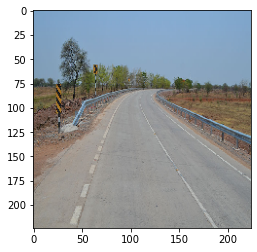

17.image.jpg


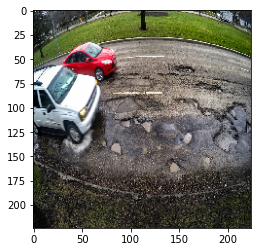

11.long-stretch-of-straight-blacktop-highway-through-the-namibian-desert-in-africa-PG48W1.jpg


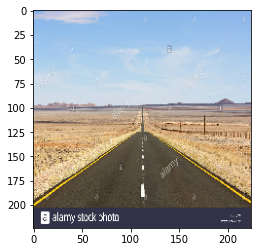

145.Pothole-full_450053_7.jpg


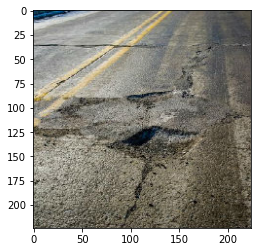

In [10]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    print(random_img)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  
    img_tensor /= 255.  
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_plain_dir)
    show_pictures(train_pothole_dir)

In [11]:
from keras.applications import VGG16

cnn = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [12]:
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512)) 
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
 
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = cnn.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 420 images belonging to 2 classes.


C:\Users\DELL\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Found 140 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [14]:
print(train_features)
print(train_labels)

[[[[1.35256541e+00 0.00000000e+00 1.12665093e+00 ... 0.00000000e+00
    7.23308086e-01 0.00000000e+00]
   [9.55278933e-01 0.00000000e+00 3.88503700e-01 ... 0.00000000e+00
    5.45308053e-01 0.00000000e+00]
   [1.21224612e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    3.73661041e-01 0.00000000e+00]
   ...
   [1.51117265e-01 0.00000000e+00 3.34225297e-02 ... 0.00000000e+00
    3.14227998e-01 0.00000000e+00]
   [3.32862824e-01 0.00000000e+00 6.44810557e-01 ... 0.00000000e+00
    7.24548876e-01 0.00000000e+00]
   [6.26276433e-01 0.00000000e+00 9.99151945e-01 ... 0.00000000e+00
    7.39526391e-01 0.00000000e+00]]

  [[1.07379007e+00 0.00000000e+00 7.90291250e-01 ... 0.00000000e+00
    9.10702229e-01 0.00000000e+00]
   [4.60996836e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.68392813e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.88532484e-01 0.00000000e+00]
   ...
   [1.37324035e-01 0.00000000e+00 1.01278365e-01 ... 0.00

In [15]:
train_features.shape

(420, 7, 7, 512)

In [16]:
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',  
              metrics=['acc'])

In [18]:
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 1s 66ms/step - loss: 0.9510 - acc: 0.6762 - val_loss: 0.1601 - val_acc: 0.9500
Epoch 2/100
14/14 [==============================] - 1s 38ms/step - loss: 0.1275 - acc: 0.9597 - val_loss: 0.1824 - val_acc: 0.9357
Epoch 3/100
14/14 [==============================] - 1s 38ms/step - loss: 0.1719 - acc: 0.9580 - val_loss: 0.1412 - val_acc: 0.9643
Epoch 4/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0711 - acc: 0.9742 - val_loss: 0.1034 - val_acc: 0.9643
Epoch 5/100
14/14 [==============================] - 1s 36ms/step - loss: 0.0711 - acc: 0.9702 - val_loss: 0.1136 - val_acc: 0.9786
Epoch 6/100
14/14 [==============================] - 1s 102ms/step - loss: 0.0121 - acc: 0.9941 - val_loss: 0.1250 - val_acc: 0.9786
Epoch 7/100
14/14 [==============================] - 2s 115ms/step - loss: 0.0257 - acc: 0.9866 - val_loss: 0.1162 - val_acc: 0.9643
Epoch 8/100
14/14 [==============================] - 1s 36ms/step - loss: 

In [19]:
model.save('pothole_fcl.h5')

In [15]:
from tensorflow import keras
model = keras.models.load_model('pothole_fcl.h5')

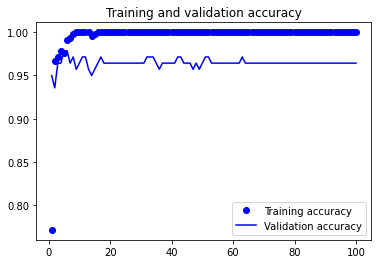

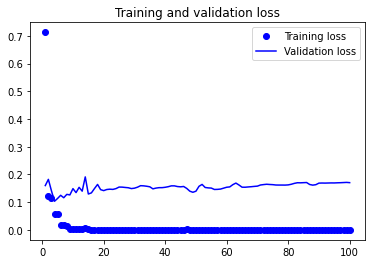

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_plain_dir, test_pothole_dir])

       
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img) 
        img_tensor /= 255.  

        features = cnn.predict(img_tensor.reshape(1,img_width, img_height, 3))

        
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        
        plt.imshow(img_tensor)
        plt.show()

        
        if prediction < 0.5:
            print('Plain')
        else:
            print('Pothole')

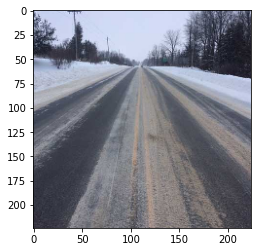

Plain


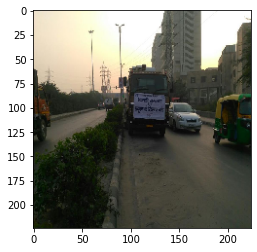

Plain


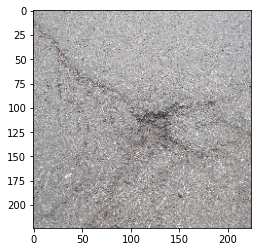

Pothole


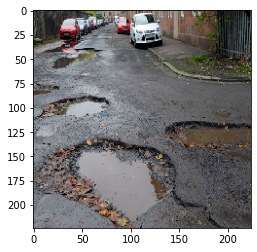

Pothole


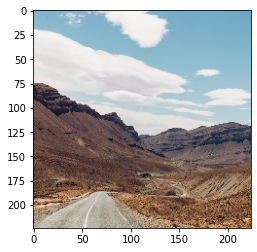

Plain


In [23]:

visualize_predictions(model, 5)

In [19]:
def predict_class_single_img(img_path,classifier=model):
    
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img) 
    img_tensor /= 255. 

    features = cnn.predict(img_tensor.reshape(1,img_width, img_height, 3))


    try:
        prediction = classifier.predict(features)
    except:
        prediction = classifier.predict(features.reshape(1, 7*7*512))

    plt.imshow(img_tensor)
    plt.show()

    if prediction < 0.5:
        print('Plain')
    else:
        print('Pothole')

## Fully Connected Layer Model

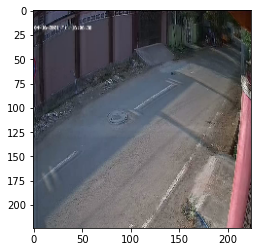

Plain


In [20]:
predict_class_single_img("cctv.jpeg",model)

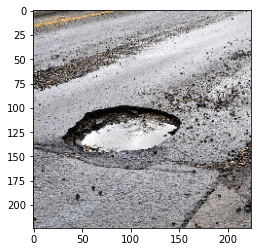

Pothole


In [24]:
predict_class_single_img("pothole_img.jpg")